In [1]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima

In [2]:
#Import datasets
nights = pd.read_csv('DS/nights_2010-2017.csv', index_col='date', parse_dates=['date'],usecols=[*range(1, 15)])
temp = pd.read_csv('DS/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
daysoff = pd.read_csv('DS/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('DS/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

In [3]:
# df with endog data for training set
rc = 'PDL' #region code

endog_rc = pd.concat([nights, gdp], axis=1)
endog_rc = endog_rc.dropna()
endog_rc = endog_rc[['nights_'+rc,'gdp_'+rc]]

# df with exog data for training set
exog_rc = pd.concat([temp, daysoff], axis=1)
exog_rc = exog_rc[['avgtemp_'+rc,'daysoff']]     # DF format for seasonal decompose

# df with nights only for testing set
nights_rc = nights[['nights_'+rc]]

Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 11
RMSE test: 24.413645774483737
MAE test: 20.36636661958048
-------


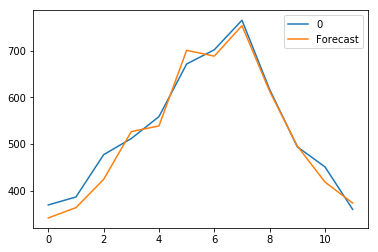

Years of training data: ['2010', '2011', '2012']
Predicted year: 2013-01-01
VAR lag order: 11
RMSE test: 33.265913790769254
MAE test: 24.117681813735924
-------


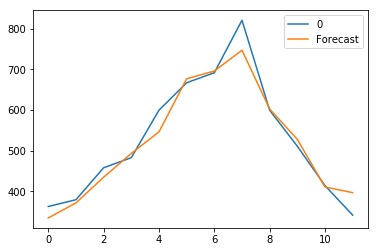

Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2014-01-01
VAR lag order: 11
RMSE test: 64519.03125325552
MAE test: 34706.97871564581
-------


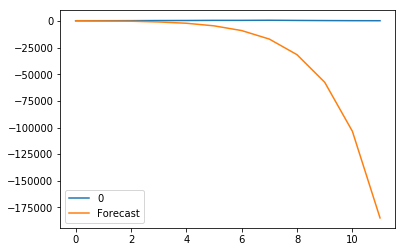

Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 11
RMSE test: 41.99625729790005
MAE test: 34.127986216943334
-------


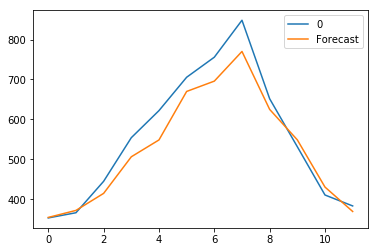

In [4]:
# Make sure to fill these in for each region! Input data must have datetime as index

input_data = endog_rc         # dataframe-type dataset # Endog
target = nights_rc           # dataframe-type dataset
exog = exog_rc
start_year = '2010-01-01'     # date as string

for index in range(2012, 2016):
    end_year = str(index)+'-01-01'
    predict_year = str(index+1)+'-01-01'
    
    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (target.index>=end_year)&(target.index<predict_year)
    
    train_data = input_data[training_period]
    test_data = np.array(target[testing_period]) # Array format to calculate errors at the end
        
    exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year) ]
    exog_future_data = exog[(exog.index>=end_year)&(exog.index<predict_year)]
    
    # --------Seasonal decompose----------
    
    # - IMPORTANT - Change model (multiplicative or additive) based on season type of nights
    decomposed_data = seasonal_decompose(train_data, model='additive')  

    seasonal_data = decomposed_data.seasonal.dropna()
    trend_data = decomposed_data.trend.dropna()
    residual_data = decomposed_data.resid.dropna()
    
    exog_resid = seasonal_decompose(exog_train_data, model='additive')
    exog_resid_data = exog_resid.resid.dropna()
    
    # ---------Seasonal prediction (Same as last year of training data)---------

    # Duplicate last year's seasonal data
    seasonal_forecast = seasonal_data[(seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
    
    # Forecasted DF without datetime index and only 12 months to be able to recompose later
    # - IMPORTANT - Replace nights_PAC below with column name for your region
    seasonal_forecast_df = pd.DataFrame(seasonal_forecast['nights_'+rc].values[-12:])
    
    # --------Trend prediction (Linear Holt)----------
    
    # Holt model (w/ optimized fit) on nights
    # - IMPORTANT - Replace nights_PAC below with column name for your region
    trend_model = Holt(trend_data['nights_'+rc]).fit(optimized=True)
    
    # Predict 12 months of trend
    trend_forecast = trend_model.predict(start=0, end=11)
    
    # Forecasted DF without datetime index to be able to recompose later
    trend_forecast_df = pd.DataFrame(trend_forecast.values) 
    
    # --------Residual prediction (VAR)----------

    # VAR model: Don't use maxlags, use specific lags in fit argument below
    #print('residual_data')
    #print(residual_data)
    #print('exog_resid_data')
    #print(exog_resid_data)
    resid_model = VAR(endog=residual_data, exog=exog_resid_data, dates=residual_data.index)
    # - IMPORTANT - Replace lag number in fit below with desired lags
    resid_results = resid_model.fit(11, trend='nc')
    
    lag_order = resid_results.k_ar

    # Forecasted DF without datetime index to be able to recompose later
    resid_forecast_df = pd.DataFrame(resid_results.forecast(residual_data.values[-lag_order:], 12, 
                                                            exog_future=exog_future_data))

    # --------Recomposing results----------
    # - IMPORTANT - Addition if additive series /// Multiplication if multiplicative series
    forecast = seasonal_forecast_df[0] + trend_forecast_df[0] + resid_forecast_df[0]
    
    
    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
    
    print('Years of training data:', train_data.index.strftime('%Y').unique().tolist())
    print('Predicted year:', end_year)
    print('VAR lag order:', lag_order)
    print('RMSE test:', rmse_test)
    print('MAE test:', mae_test)
    print('-------')
    pd.DataFrame(test_data).plot(label='Real')
    forecast.plot(label='Forecast')
    plt.legend()
    plt.show()